# Beyond the Pitch — FA Presentation Notebook
**Topic:** English-Qualified Representation in the WSL (SoccerDonna scrape)  
**Purpose:** 7 visuals for a 10-minute presentation to support England Women's Recruitment Data Analyst interview (The FA).  
**Author:** Louise Randall

---

This notebook loads the scraped SoccerDonna Excel file, cleans key fields, and produces Matplotlib / Seaborn charts aligned to the FA storytelling theme: *identifying English-qualified player representation and implications for recruitment and pathway development*.


### ==============================================
### 1) Imports and settings
### ==============================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(style='whitegrid')
%matplotlib inline

# Make plots look slightly larger for presentations
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 10


### ==============================================
### 2) Load the Saved Excel File
### ==============================================

In [2]:
file_path = "womens-super-league_ENG1_players.xlsx"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Expected file at {file_path} — please upload it to the working directory.")

df = pd.read_excel(file_path)
print("Loaded dataframe shape:", df.shape)
df.columns = [c.strip() for c in df.columns]
df.head()

Loaded dataframe shape: (318, 18)


,Club,Profile URL,Name,Date of birth,Place of birth,Age,Name in native country,Height,Nationality,Position,Foot,Market value,Contract until,Debut (Club),Contract option,Unnamed: 15,2.Club (Number),Outfitter
0,Chelsea FC,https://www.soccerdonna.de/en/livia-peng/profi...,1 Livia Peng,14.03.2002,Chur,23,Livia Maïté Peng,"1,74",Switzerland,Goalkeeper,right,140.000 €,30.06.2029,08.10.2025,NaN,NaN,NaN,NaN
1,Chelsea FC,https://www.soccerdonna.de/en/hannah-hampton/p...,24 Hannah Hampton,16.11.2000,Birmingham,24,Hannah Alice Hampton,"1,75",England,Goalkeeper,right,210.000 €,30.06.2026,17.12.2023,NaN,NaN,NaN,NaN
2,Chelsea FC,https://www.soccerdonna.de/en/rebecca-spencer/...,38 Rebecca Spencer,22.02.1991,Harrow,34,Rebecca Leigh Spencer,"1,67",Jamaica England,Goalkeeper,right,35.000 €,30.06.2026,27.04.2016,NaN,NaN,NaN,NaN
3,Chelsea FC,https://www.soccerdonna.de/en/brooke-aspin/pro...,Brooke Aspin,01.07.2005,Tiverton,20,NaN,"1,71",England,Defence - Centre Back,right,30.000 €,30.06.2027,NaN,NaN,NaN,NaN,NaN
4,Chelsea FC,https://www.soccerdonna.de/en/ellie-carpenter/...,2 Ellie Carpenter,28.04.2000,Cowra,25,Ellie Madison Carpenter,"1,64",Australia,"Defence - Fullback, right",right,550.000 €,30.06.2029,05.09.2025,NaN,NaN,NaN,NaN


### ==============================================
### 3) Basic Cleaning & preparation
### ==============================================

In [3]:
# Trim whitespace in string columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

# Ensure key columns exist (if not, create placeholders)
expected_cols = ['Club','Name','Age','Nationality','Position','Market value']
for c in expected_cols:
    if c not in df.columns:
        df[c] = np.nan
        print(f"WARNING: Column '{c}' not found — created placeholder column.")

# Derive English_Qualified flag (contains 'England' in Nationality)
df['English_Qualified'] = df['Nationality'].fillna('').str.contains('England', case=False, na=False)

# Clean Age to numeric if possible
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Clean Market value: try to extract numeric euros (handles formats like '140.000 €' or '1,000,000 €')
def parse_market_value(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x)
        s = s.replace('€','').replace(' ','').replace('\xa0','').replace(',','')
        s = s.replace('.', '')
        return float(s)
    except Exception:
        return np.nan

if 'Market value' in df.columns:
    df['MarketValue_EUR'] = df['Market value'].apply(parse_market_value)
else:
    df['MarketValue_EUR'] = np.nan

# Clean Height to numeric (if exists)
if 'Height' in df.columns:
    df['Height_m'] = (
        df['Height'].astype(str)
        .str.replace(',', '.')
        .str.extract(r'(\d+\.\d+|\d+)')
        .astype(float)
    )

# Simplify Position to broad categories (e.g., Defence, Midfield, Forward)
if 'Position' in df.columns:
    df['PositionGroup'] = df['Position'].str.split('-').str[0].str.strip()
else:
    df['PositionGroup'] = np.nan

print('English qualified counts:')
print(df['English_Qualified'].value_counts(dropna=False))
df[['Club','Name','Age','Nationality','English_Qualified','MarketValue_EUR']].head()
print("\n✅ DataFrame cleaned successfully!")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Missing Market Values: {df['MarketValue_EUR'].isna().sum()}")
print(f"English-Qualified Players: {df['English_Qualified'].sum()} / {len(df)} total")
print(df[['Height_m','PositionGroup']].describe(include='all'))


English qualified counts:
False    187
True     131
Name: English_Qualified, dtype: int64

✅ DataFrame cleaned successfully!
Rows: 318, Columns: 22
Missing Market Values: 40
English-Qualified Players: 131 / 318 total
          Height_m PositionGroup
count   279.000000           318
unique         NaN             4
top            NaN       Defence
freq           NaN           112
mean      1.689749           NaN
std       0.062187           NaN
min       1.510000           NaN
25%       1.650000           NaN
50%       1.690000           NaN
75%       1.730000           NaN
max       1.850000           NaN


### ==============================================
### 4) Visuals & Storytelling (FA Theme)
### ==============================================

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# FA colour palette
fa_red = "#DA291C"
fa_navy = "#1C2C5B"
fa_grey = "#C8C9CA"
fa_white = "#FFFFFF"
fa_background = "#F7F7F8"

# --- Global Matplotlib Style ---
plt.rcParams.update({
    'axes.edgecolor': fa_grey,
    'axes.labelcolor': fa_navy,
    'axes.titlecolor': fa_navy,
    'xtick.color': fa_navy,
    'ytick.color': fa_navy,
    'text.color': fa_navy,
    'figure.facecolor': fa_background,
    'axes.facecolor': fa_white
})

# --- Helper function for consistent styling ---
def fa_style(ax, title):
    ax.set_title(title, fontsize=14, fontweight='bold', color=fa_navy, pad=15)
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)
    return ax




### ======================================================
### Nationality Mix: English-qualified vs International
### ======================================================

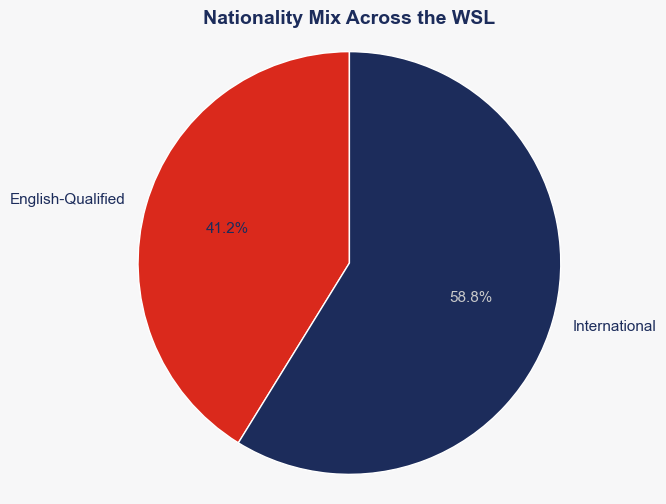

Nationality mix breakdown:
English-Qualified    131
International        187
Name: English_Qualified, dtype: int64


In [5]:
# Build a labelled Series to ensure labels always align with values
nationality_mix = (
    df['English_Qualified']
    .value_counts(dropna=False)
    .rename(index={True: 'English-Qualified', False: 'International'})
)

# Ensure both labels always exist
for label in ['English-Qualified', 'International']:
    if label not in nationality_mix.index:
        nationality_mix[label] = 0

# Sort for consistent colour order (English first)
nationality_mix = nationality_mix.reindex(['English-Qualified', 'International'])

fig, ax = plt.subplots(figsize=(6, 6))
colors = [fa_red, fa_navy]

# Draw pie chart
wedges, texts, autotexts = ax.pie(
    nationality_mix.values,
    labels=nationality_mix.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11}
)

# Adjust percentage text colours
for i, autotext in enumerate(autotexts):
    if colors[i] == fa_navy:
        autotext.set_color(fa_grey)  # readable on dark blue
    else:
        autotext.set_color(fa_navy)  # red segment readable in navy

# Title and styling
ax.set_title("Nationality Mix Across the WSL", fontsize=14, fontweight='bold', color=fa_navy)
ax.axis('equal')  # Equal aspect ratio for perfect circle
plt.show()

# Print summary
print("Nationality mix breakdown:")
print(nationality_mix)


### ------------------------------------------------------
### Top 10 Clubs by Total Market Value (€)
### ------------------------------------------------------

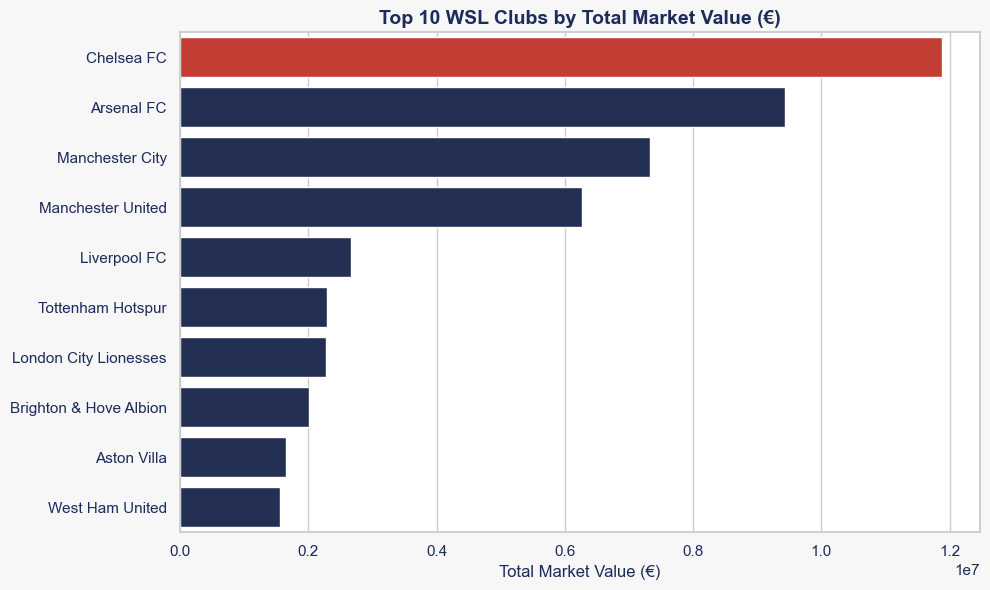

In [6]:
club_values = (
    df.groupby('Club')['MarketValue_EUR']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    x=club_values.values,
    y=club_values.index,
    palette=[fa_red if i == 0 else fa_navy for i in range(len(club_values))],
    ax=ax
)

ax.set_title("Top 10 WSL Clubs by Total Market Value (€)", fontsize=14, fontweight='bold', color=fa_navy)
ax.set_xlabel("Total Market Value (€)", fontsize=12)
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
plt.tight_layout()
plt.show()


### ------------------------------------------------------
### Market Value vs Age (Scatterplot)
### ------------------------------------------------------

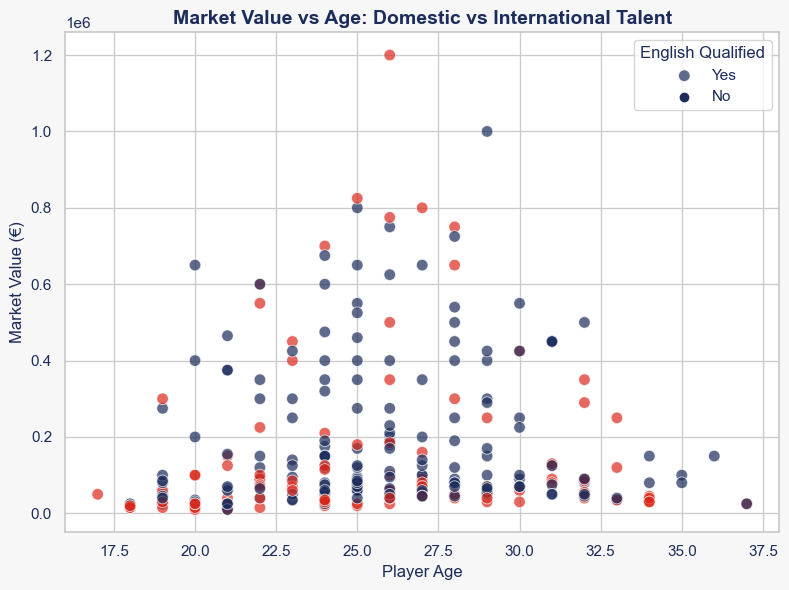

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='Age',
    y='MarketValue_EUR',
    hue='English_Qualified',
    palette={True: fa_red, False: fa_navy},
    alpha=0.7,
    s=70,
    ax=ax
)

ax.set_title("Market Value vs Age: Domestic vs International Talent", fontsize=14, fontweight='bold', color=fa_navy)
ax.set_xlabel("Player Age", fontsize=12)
ax.set_ylabel("Market Value (€)", fontsize=12)
ax.legend(title="English Qualified", labels=["Yes", "No"])
plt.tight_layout()
plt.show()


### ------------------------------------------------------
### Age Distribution by Position
### ------------------------------------------------------

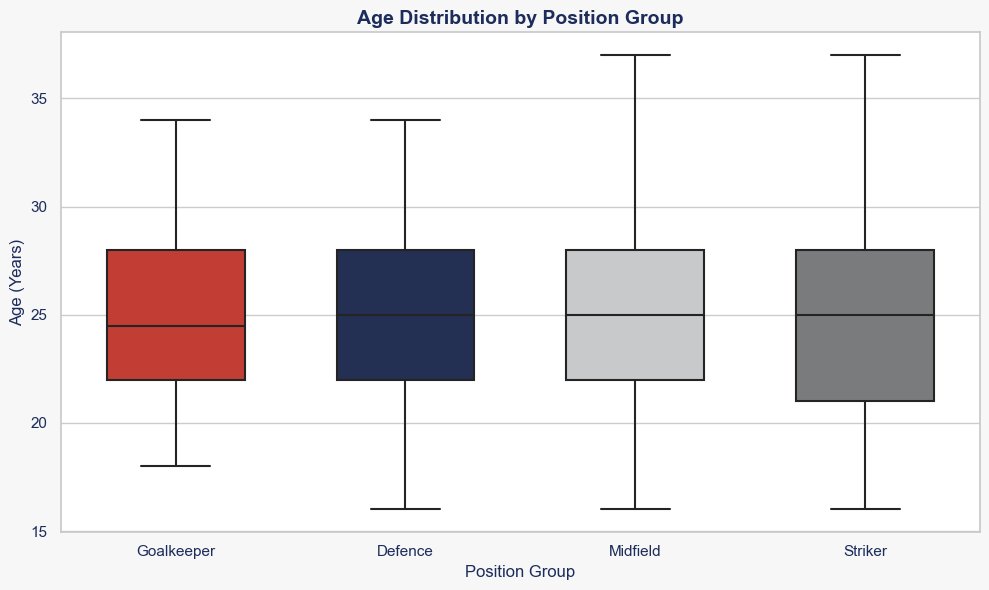

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='PositionGroup',
    y='Age',
    palette=[fa_red, fa_navy, fa_grey, "#7A7B7C"],  # red for defenders, navy for mids, etc.
    width=0.6,
    ax=ax
)

ax.set_title("Age Distribution by Position Group", fontsize=14, fontweight='bold', color=fa_navy)
ax.set_xlabel("Position Group", fontsize=12)
ax.set_ylabel("Age (Years)", fontsize=12)
plt.tight_layout()
plt.show()

### ------------------------------------------------------
### Emerging English U23 Players (Watchlist)
### ------------------------------------------------------

Emerging English U23 Players (Top 10)


,Name,Age,Club,PositionGroup,MarketValue_M
0,6 Grace Clinton,22.0,Manchester City,Midfield,0.600
1,33 Aggie Beever-Jones,22.0,Chelsea FC,Striker,0.550
2,9 Michelle Agyemang,19.0,Brighton & Hove Albion,Striker,0.300
3,19 Laura Blindkilde Brown,22.0,Manchester City,Midfield,0.225
4,35 Khiara Keating,21.0,Manchester City,Goalkeeper,0.150
5,3 Naomi Layzell,21.0,Manchester City,Defence,0.125
6,8 Maisie Symonds,22.0,Brighton & Hove Albion,Midfield,0.100
7,13 Mia Enderby,20.0,Liverpool FC,Striker,0.100
8,18 Lenna Gunning-Williams,20.0,Tottenham Hotspur,Striker,0.100
9,23 Isobel Goodwin,22.0,London City Lionesses,Striker,0.090


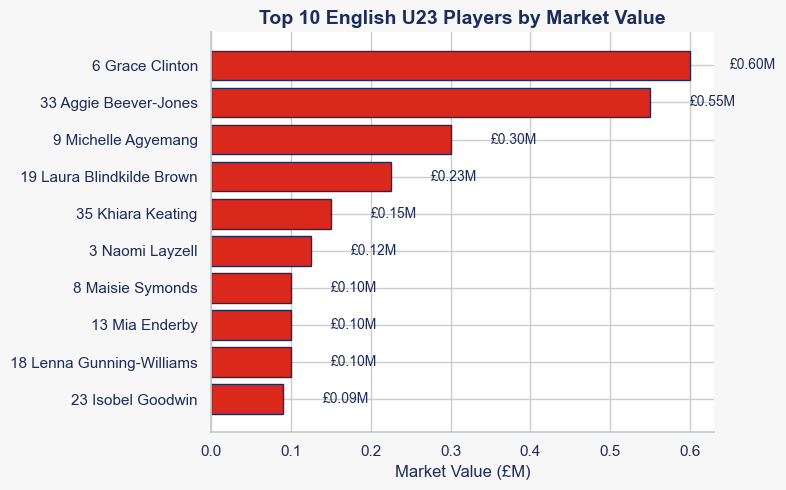

In [9]:
# Convert market value to millions of pounds (approximate conversion from euros)
df['MarketValue_M'] = df['MarketValue_EUR'] / 1_000_000  # values in £M

# Filter English-qualified players under 23
u23_watchlist = df[
    (df['English_Qualified'] == True) &
    (df['Age'] < 23)
][['Name', 'Age', 'Club', 'PositionGroup', 'MarketValue_M']].copy()

# Sort by Market Value descending
u23_watchlist = u23_watchlist.sort_values(by='MarketValue_M', ascending=False).head(10)

# Display table
print(f"Emerging English U23 Players (Top {len(u23_watchlist)})")
display(u23_watchlist.reset_index(drop=True))

# Optional: Styled table
def style_watchlist(s):
    return (
        s.style
        .set_caption("⭐ Emerging English U23 Players – WSL 2024/25 Season")
        .set_table_styles([
            {'selector': 'caption',
             'props': [('color', fa_navy), ('font-size', '14px'),
                       ('font-weight', 'bold'), ('text-align', 'center'),
                       ('padding', '8px')]},
            {'selector': 'th',
             'props': [('background-color', fa_red), ('color', 'white'),
                       ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td',
             'props': [('text-align', 'center'), ('border', '1px solid #ddd'),
                       ('padding', '6px')]}
        ])
        .format({'MarketValue_M': '£{:.2f}M'})
    )

style_watchlist(u23_watchlist)

# --- Bar Chart for Visual Storytelling ---
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.barh(
    u23_watchlist['Name'],
    u23_watchlist['MarketValue_M'],
    color=fa_red,
    edgecolor=fa_navy
)

# Reverse y-axis so highest value is at top
ax.invert_yaxis()

# Titles and labels
ax.set_title("Top 10 English U23 Players by Market Value", fontsize=14, fontweight='bold', color=fa_navy)
ax.set_xlabel("Market Value (£M)", fontsize=12, color=fa_navy)
ax.set_ylabel("", fontsize=12)

# Annotate values
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.05, bar.get_y() + bar.get_height()/2,
            f"£{width:.2f}M", va='center', ha='left', color=fa_navy, fontsize=10)

# Clean visual style
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(colors=fa_navy)
plt.tight_layout()
plt.show()


# Conclusion & FA Relevance

**Key takeaways**:
- Representation of English-qualified players varies significantly by club — this helps target scouting and monitoring resources.
- Age and market-value patterns indicate where emerging talent may be underexposed.
- The analysis can be turned into an automated dashboard (BigQuery backend -> Tableau) for near real-time monitoring and talent alerts.

**Suggested next steps** for a Recruitment Data Analyst at the FA:
1. Integrate this dataset into a scheduled ETL pipeline and store in BigQuery.
2. Enrich with minutes/appearance/event data to compute per-90 metrics.
3. Build role-specific monitoring dashboards (U23 watchlists, position gaps, dual-nationality flags).
4. Collaborate with recruitment coaches to set thresholds and triggers for scouting activity.
